# Deep Models

In [22]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from scipy.stats import norm
import GPy

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib.ticker import FuncFormatter

from utils import *

from utils import *
from models import *
from constants import *

## Data Analysis

In [23]:
keras.utils.set_random_seed(812)

In [24]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned_temp/train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned_temp/test.pkl','rb'))

In [25]:
df_train.head()

,index,Date.time,Wind.dir.std,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Power.factor.cosphi.me,Power.factor.cosphi.sd,Power.factor.cosphi.min,Power.factor.cosphi.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,Rear.bearing.temp.sd,Rear.bearing.temp.min,Rear.bearing.temp.max,Stator1.temp.me,Stator1.temp.sd,Stator1.temp.min,Stator1.temp.max,Nacelle.ambient.temp.me,Nacelle.ambient.temp.sd,Nacelle.ambient.temp.min,Nacelle.ambient.temp.max,Nacelle.temp.me,Nacelle.temp.sd,Nacelle.temp.min,Nacelle.temp.max,Transformer.temp.me,Transformer.temp.sd,Transformer.temp.min,Transformer.temp.max,Gear.oil.inlet.temp.me,Gear.oil.inlet.temp.sd,Gear.oil.inlet.temp.min,Gear.oil.inlet.temp.max,Generator.bearing.rear.temp.me,Generator.bearing.rear.temp.sd,Generator.bearing.rear.temp.min,Generator.bearing.rear.temp.max,Generator.bearing.front.temp.me,Generator.bearing.front.temp.sd,Generator.bearing.front.temp.min,Generator.bearing.front.temp.max,Gear.oil.temp.me,Gear.oil.temp.sd,Gear.oil.temp.min,Gear.oil.temp.max,Top.box.temp.me,Top.box.temp.sd,Top.box.temp.min,Top.box.temp.max,Hub.temp.me,Hub.temp.sd,Hub.temp.min,Hub.temp.max,Conv.Amb.temp.me,Conv.Amb.temp.sd,Conv.Amb.temp.min,Conv.Amb.temp.max,Rotor.bearing.temp.me,Rotor.bearing.temp.sd,Rotor.bearing.temp.min,Rotor.bearing.temp.max,Transformer.cell.temp.me,Transformer.cell.temp.sd,Transformer.cell.temp.min,Transformer.cell.temp.max,Motor.axis1.temp.me,Motor.axis1.temp.sd,Motor.axis1.temp.min,Motor.axis1.temp.max,Motor.axis2.temp.me,Motor.axis2.temp.sd,Motor.axis2.temp.min,Motor.axis2.temp.max,Motor.axis3.temp.me,Motor.axis3.temp.sd,Motor.axis3.temp.min,Motor.axis3.temp.max,CPU.temp.me,CPU.temp.sd,CPU.temp.min,CPU.temp.max,Rotor.speed.me,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.A.sd,Blade.ang.pitch.pos.A.min,Blade.ang.pitch.pos.A.max,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.B.sd,Blade.ang.pitch.pos.B.min,Blade.ang.pitch.pos.B.max,Blade.ang.pitch.pos.C.me,Blade.ang.pitch.pos.C.sd,Blade.ang.pitch.pos.C.min,Blade.ang.pitch.pos.C.max,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year,Wind.dir.sin.me,Wind.dir.cos.me,Wind.dir.sin.min,Wind.dir.cos.min,Wind.dir.sin.max,Wind.dir.cos.max
0,0,2017-09-25 00:00:00,5.049604,200.121521,23.819124,157.306244,240.665955,236.830036,5.171129,0.390980,4.240140,5.912565,-0.928713,0.014111,-0.948315,-0.891933,67.665001,0.194358,67.350006,68.099998,67.337502,0.194857,67.099998,67.800003,60.404999,NaN,NaN,NaN,14.902499,NaN,NaN,NaN,27.130001,NaN,NaN,NaN,40.917500,NaN,NaN,NaN,56.827499,NaN,NaN,NaN,41.165001,NaN,NaN,NaN,42.900002,NaN,NaN,NaN,58.312500,NaN,NaN,NaN,27.565001,NaN,NaN,NaN,24.0,NaN,NaN,NaN,17.320000,NaN,NaN,NaN,32.240002,NaN,NaN,NaN,19.745001,NaN,NaN,NaN,28.0,NaN,NaN,NaN,28.952381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,8.963050,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,80.076599,355.346771,44.632309,22.022369,14.627177,1,2017,0.480302,-0.877103,0.606593,-0.795012,0.320156,-0.947365
1,1,2017-09-25 00:10:00,3.185307,196.931503,11.779391,174.080612,224.724045,221.866237,5.090679,0.436131,4.303428,5.930200,-0.919313,0.008427,-0.936939,-0.903545,67.764999,0.137932,67.500000,68.000000,67.527496,0.095491,67.400002,67.699997,61.512501,NaN,NaN,NaN,14.860000,NaN,NaN,NaN,27.305000,NaN,NaN,NaN,40.812500,NaN,NaN,NaN,56.980000,NaN,NaN,NaN,41.680000,NaN,NaN,NaN,43.724998,NaN,NaN,NaN,58.400002,NaN,NaN,NaN,27.760000,NaN,NaN,NaN,24.0,NaN,NaN,NaN,17.262501,NaN,NaN,NaN,32.197502,NaN,NaN,NaN,19.672501,NaN,NaN,NaN,28.0,NaN,NaN,NaN,28.869566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,8.942242,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,79.719238,353.837952,43.258904,20.714163,10.469490,1,2017,0.530766,-0.847518,0.611328,-0.791378,0.464390,-0.885631
2,2,2017-09-25 00:20:00,5.830245,197.651825,11.052958,174.656937,214.682724,240.928125,5.19316

In [65]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]
df_train_single.reset_index(drop=True, inplace=True)
print(f"Turbine#{TURBINE_ID} Training Set Size: ", df_train_single.shape[0])
print(f"Turbine#{TURBINE_ID} Testing Set Size: ", df_test_single.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  677572
Full Testing Set Size:  169396
Turbine#5 Training Set Size:  130849
Turbine#5 Testing Set Size:  32713


In [27]:
descriptive_stats = df[FEATURES + [OUTPUT_FEATURE]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Wind.dir.std,Wind.dir.sin.me,Wind.dir.sin.min,Wind.dir.sin.max,Wind.dir.cos.me,Wind.dir.cos.min,Wind.dir.cos.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,Rear.bearing.temp.sd,Rear.bearing.temp.min,Rear.bearing.temp.max,Stator1.temp.me,Nacelle.ambient.temp.me,Nacelle.temp.me,Transformer.temp.me,Gear.oil.temp.me,Gear.oil.inlet.temp.me,Top.box.temp.me,Hub.temp.me,Conv.Amb.temp.me,Transformer.cell.temp.me,Motor.axis1.temp.me,Motor.axis2.temp.me,CPU.temp.me,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.C.me,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,Power.me
count,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000,163562.000000
mean,6.059520,0.920069,4.303416,7.808345,9.785958,-0.235938,-0.162549,-0.281645,-0.117417,-0.180736,-0.016475,65.616563,0.612498,64.597796,66.602066,63.534438,0.647323,62.468641,64.576326,62.557715,10.286856,19.490236,48.304518,52.279911,48.589007,24.555746,19.988919,14.039858,16.326339,41.118457,41.575385,53.243780,3.847028,3.847020,3.847339,117.787381,457.240337,20.351336,57.655458,27.858859,618.824383
std,2.641360,0.448340,2.101718,3.327853,5.408072,0.672357,0.640712,0.681383,0.691728,0.728290,0.675372,9.826718,0.507878,9.623372,10.043471,8.494427,0.572169,8.245937,8.780093,7.572731,5.846763,5.328638,19.314746,5.847799,8.099389,3.387246,4.894973,6.010122,5.924738,18.315887,18.554529,3.154664,12.049325,12.049338,12.049658,53.682028,162.366956,35.076342,29.984541,14.987320,613.637384
min,0.129863,0.000000,-0.444250,0.243750,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,14.565001,0.000000,14.400000,14.600000,13.147500,0.000000,13.100000,13.200000,14.170000,-6.800000,1.245000,18.690001,13.857500,9.235000,9.520000,7.762000,-2.642500,-1.037500,10.400000,11.000000,38.000000,0.000000,0.000000,0.000000,-4.160219,5.963073,3.108314,2.198514,2.563780,-18.075356
25%,4.194074,0.592671,2.790378,5.501348,6.743531,-0.849297,-0.768009,-0.888208,-0.786332,-0.866028,-0.691433,61.975625,0.233432,61.099998,62.900002,61.810000,0.234840,61.099998,62.549999,59.697499,6.000000,15.925000,35.482500,49.630001,42.457500,22.922501,16.048500,9.612054,11.837500,27.000000,27.200000,52.000000,0.000000,0.000000,0.000000,83.707560,353.652039,5.052327,37.206526,17.741370,138.623232
50%,5.725916,0.846816,4.087525,7.341903,8.873859,-0.429888,-0.209368,-0.515006,-0.265955,-0.426199,-0.044709,69.875000,0.472626,68.500000,71.000000,66.270000,0.457193,65.099998,67.099998,62.022499,9.670000,19.505719,41.920000,53.460000,50.767500,24.912500,19.000000,13.540000,16.014999,36.000000,36.336750,53.500000,0.017500,0.017500,0.017500,98.001991,403.493604,7.353079,55.338648,25.871829,387.006336
75%,7.574086,1.171979,5.556932,9.695852,11.512664,0.381681,0.379539,0.256671,0.584493,0.569114,0.622501,72.267499,0.848996,71.199997,73.300003,68.635002,0.885678,67.199997,70.099998,64.439868,14.245000,23.010000,53.230000,56.502500,55.352380,26.362499,23.000000,18.135000,20.417500,52.444333,52.499500,55.000000,0.807641,0.807873,0.808267,147.683380,552.892154,13.901659,77.738857,35.638125,937.105292
max,19.714199,5.016237,14.472502,28.003450,104.579658,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,81.182500,7.816919,80.800003,81.449997,75.092500,7.473754,74.649994,76.400002,103.014999,35.225000,39.362499,107.987503,59

In [28]:
X_train_full, X_test_full,\
    y_train_full, y_test_full,\
    scaler_full = create_design_matrix(df_train, df_test, FEATURES, OUTPUT_FEATURE)

X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

dump(scaler, 'saved_models/scaler_full.joblib')
dump(scaler, 'saved_models/scaler.joblib')

assert X_train.shape[0] < X_train_full.shape[0]

In [29]:
X_train.shape

(130849, 40)

## Bayesian Neural Networks (Probabilistic Output)

We introduce a probabilistic output to a Bayesian network with the same number of layers as the previous but more hidden units. This way we model the output as a univariate distribution parametrized via a mean and a variance functions in the input space of the network. The loss becomes the negative log-likelihood of the identically and indipendently distributed data points. Where the distribution is a univariate Normal with a mean function and variance function paramettrized by the model.

### Dense Flipout + Gaussian Output

In [30]:
model_bnn = create_model_bnn(X_train, MODELS_SEED)
model_path = "bnn"

 c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning:`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
 c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning:`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense_flipout (DenseFlipou  (None, 80)                12880     
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 50)                16050     
 out)                                                            
                                                                 
 dense_flipout_2 (DenseFlip  (None, 20)                4020      
 out)                                                            
                                                                 
 dense (Dense)               (None, 2)                 42        
                                                             

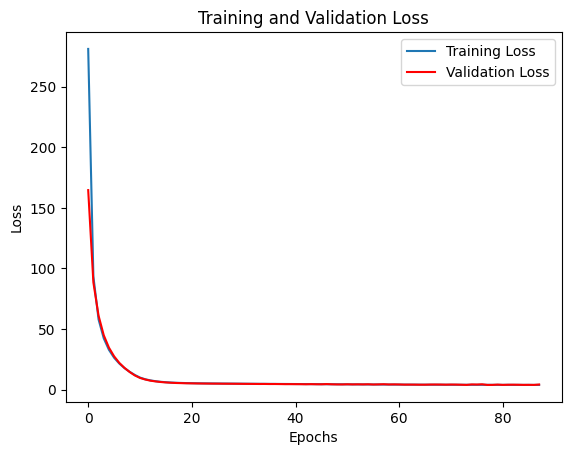

In [31]:
if TRAIN == True:
    cp_callback = ModelCheckpoint(filepath=overwrite(f"saved_models_paper3/{model_path}.keras"),
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_bnn,
                          X_train, y_train,
                          patience=10, epochs=HUNDRED, batch_size=256,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [32]:
model_bnn.load_weights(f"saved_models_paper3/{model_path}.keras")
model_bnn.evaluate(X_test, y_test)

1023/1023 [==============================] - 5s 5ms/step - loss: 4.1742


4.1741838455200195

In [33]:
y_train_pred = np.array(model_bnn(X_train).mean()).ravel()
y_test_pred = np.array(model_bnn(X_test).mean()).ravel()

y_train_stddevs = np.array(model_bnn(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_bnn(X_test).stddev()).ravel()

name = "BNN"

save_preds(name, y_test_pred, y_test_stddevs, filename="preds_paper.csv")

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL,
                           output_file="results_paper.csv")

Train RMSE: 37.447
Test RMSE: 40.284
Train MAE: 20.601
Test MAE: 22.542
Percentage of Test Data Points within 99.00% CI: 98.20%
Percentage of Test Data Points within 99.00% CI: 97.18%
Percentage of Test Data Points within 95.00% CI: 93.88%
Percentage of Test Data Points within 95.00% CI: 91.79%


## MLP (Probabilistic Output) 
We create a non-Bayesian deep model for the mean and the standard deviation of a Gaussian. 

### MLP with Gaussian Output - Joint Submodels

In [36]:
model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, MODELS_SEED)
model_path = "mlp_joint"

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  4100      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 80)                   8080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['dense_1[0][0]']             
                                                                                              

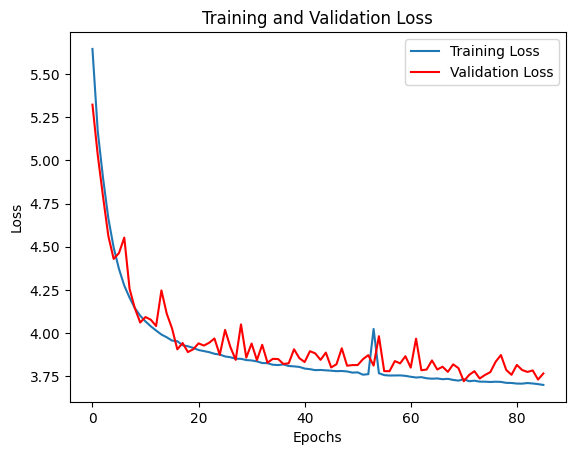

In [37]:
if TRAIN == True:
    cp_callback = ModelCheckpoint(filepath=overwrite(f"saved_models_paper3/{model_path}.keras"),
                                                     save_weights_only=True,
                                                     verbose=0)

    indices = np.random.permutation(X_train.shape[0])
    
    history = train_model(model_mlp_gaussian_joint,
                          X_train[indices], y_train[indices],
                          patience=15, epochs=HUNDRED, batch_size=32,
                          cp_callback=cp_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [38]:
model_mlp_gaussian_joint.load_weights(f"saved_models_paper3/{model_path}.keras")
model_mlp_gaussian_joint.evaluate(X_test, y_test)

1023/1023 [==============================] - 4s 4ms/step - loss: 3.8409


3.8409433364868164

In [39]:
y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

name = "PMLP A1"

save_preds(name, y_test_pred, y_test_stddevs, filename="preds_paper.csv")

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL,
                           output_file="results_paper.csv")

Train RMSE: 24.862
Test RMSE: 28.968
Train MAE: 13.475
Test MAE: 15.945
Percentage of Test Data Points within 99.00% CI: 98.81%
Percentage of Test Data Points within 99.00% CI: 97.52%
Percentage of Test Data Points within 95.00% CI: 95.37%
Percentage of Test Data Points within 95.00% CI: 92.21%


## Wind Farm Pre-training and Wind Turbine Fine-tuning: An Ablation Study

We perform an ablation stidy to evaluate if scaling the architecture and/or wind farm data pre-training can improve the predictive performance. To do so we present a larger MLP architecture and we compare the results between the Probabilistic MLP (see above) and the following models:

1. Probabilistic MLP with pre-training
2. Large Probabilistic MLP without pre-training
3. Large Probabilistic MLP with pre-training

Additionally, we investigate how well does pre-training bootstrap performance for newly installed turbines. To do so we remove WT5 data from the pre-training data set and we fine-tune six different models from the pre-training weights each with a mutually exclusive and consecutive sample of data from the data set. Each sample is taken to be two consecutive months worth of data, excluding filtering. These six fine-tuning data sets range in size between X and X.

### 1. Probabilistic MLP with pre-training

In [43]:
# Define the file path for saving the weights
checkpoint_path = 'saved_models_paper3/mlp_pretrained.keras'

# Train the initial model using X_full with the checkpoint callback
mlp_pretrained = create_model_mlp_gaussian_joint(X_train_full, MODELS_SEED)
mlp_pretrained.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  4100      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 80)                   8080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['dense_1[0][0]']             
                                                                                              

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  4100      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 80)                   8080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['dense_1[0][0]']             
                                                                                              

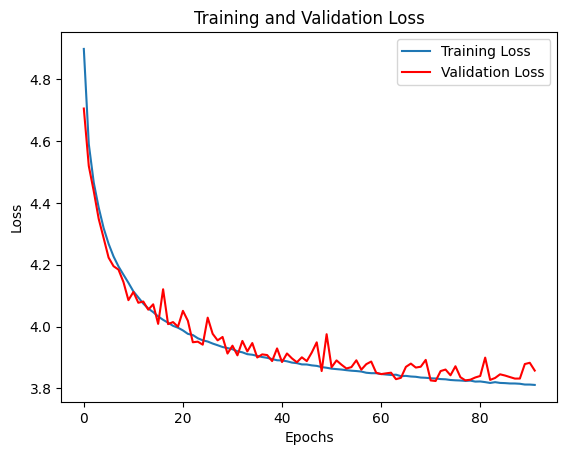

In [44]:
if TRAIN == True:
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)
    
    indices = np.random.permutation(y_train_full.shape[0])

    history = train_model(mlp_pretrained,
                          X_train_full[indices], y_train_full[indices],
                          patience=20, epochs=5*HUNDRED, batch_size=64,
                          cp_callback=checkpoint_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [45]:
mlp_pretrained.load_weights(checkpoint_path)
evaluation = mlp_pretrained.evaluate(X_test_full, y_test_full)

5294/5294 [==============================] - 13s 2ms/step - loss: 3.9286


In [46]:
checkpoint_path = 'saved_models_paper3/mlp_finetuned.keras'
mlp_finetuned = mlp_pretrained
mlp_pretrained.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  4100      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 80)                   8080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['dense_1[0][0]']             
                                                                                              

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  4100      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 80)                   8080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['dense_1[0][0]']             
                                                                                              

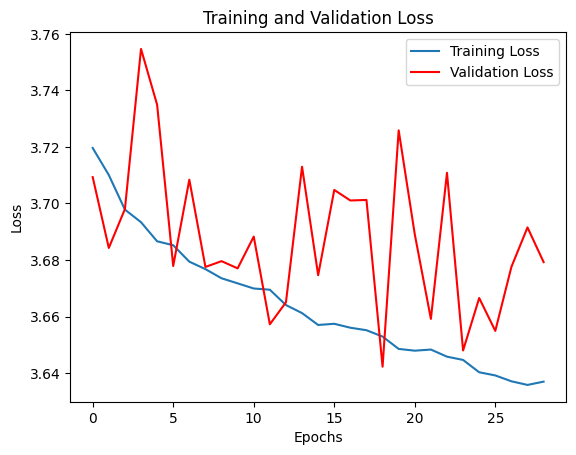

In [47]:
if TRAIN == True:
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)
    
    indices = np.random.permutation(y_train.shape[0])

    history = train_model(mlp_finetuned,
                          X_train[indices], y_train[indices],
                          patience=10, epochs=50, batch_size=32,
                          cp_callback=checkpoint_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)

In [48]:
mlp_finetuned.load_weights(checkpoint_path)
evaluation = mlp_finetuned.evaluate(X_test, y_test)
print("Evaluation Loss:", evaluation)

1023/1023 [==============================] - 3s 2ms/step - loss: 3.7099
Evaluation Loss: 3.7098779678344727


In [49]:
y_train_pred = np.array(mlp_finetuned(X_train).mean()).ravel()
y_test_pred = np.array(mlp_finetuned(X_test).mean()).ravel()

y_train_stddevs = np.array(mlp_finetuned(X_train).stddev()).ravel()
y_test_stddevs = np.array(mlp_finetuned(X_test).stddev()).ravel()

name = "LPMLP A1"

save_preds(name, y_test_pred, y_test_stddevs, filename="preds_paper.csv")

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL,
                           output_file="results_paper.csv")

Train RMSE: 23.915
Test RMSE: 27.381
Train MAE: 12.901
Test MAE: 14.814
Percentage of Test Data Points within 99.00% CI: 99.20%
Percentage of Test Data Points within 99.00% CI: 98.40%
Percentage of Test Data Points within 95.00% CI: 96.50%
Percentage of Test Data Points within 95.00% CI: 94.56%


### 2. Large Probabilistic MLP without pre-training

In [50]:
# Define the file path for saving the weights
checkpoint_path = 'saved_models_paper3/mlp_large.keras'

# Train the initial model using X_full with the checkpoint callback
mlp_large = create_model_mlp_gaussian_large(X_train_full, MODELS_SEED)
mlp_large.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 300)               12300     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 300)               12300     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

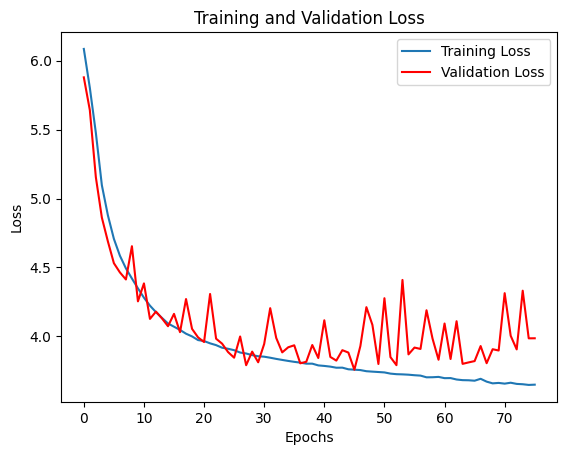

In [51]:
if TRAIN == True:
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

    indices = np.random.permutation(X_train_full.shape[0])

    history = train_model(mlp_large,
                          X_train, y_train,
                          patience=30, epochs=HUNDRED, batch_size=64,
                          cp_callback=checkpoint_callback,
                          seed=MODELS_SEED)

    plot_loss_history(history)             

In [52]:
mlp_large.load_weights(checkpoint_path)
evaluation = mlp_large.evaluate(X_test, y_test)

1023/1023 [==============================] - 5s 5ms/step - loss: 3.8553


In [53]:
y_train_pred = np.array(mlp_large(X_train).mean()).ravel()
y_test_pred = np.array(mlp_large(X_test).mean()).ravel()

y_train_stddevs = np.array(mlp_large(X_train).stddev()).ravel()
y_test_stddevs = np.array(mlp_large(X_test).stddev()).ravel()

name = "PMLP A2"

save_preds(name, y_test_pred, y_test_stddevs, filename="preds_paper.csv")

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL,
                           output_file="results_paper.csv")

Train RMSE: 25.932
Test RMSE: 28.842
Train MAE: 14.277
Test MAE: 15.936
Percentage of Test Data Points within 99.00% CI: 98.82%
Percentage of Test Data Points within 99.00% CI: 97.48%
Percentage of Test Data Points within 95.00% CI: 95.21%
Percentage of Test Data Points within 95.00% CI: 92.57%


### 3. Large Probabilistic MLP with pre-training

In [54]:
# Define the file path for saving the weights
checkpoint_path = 'saved_models_paper3/mlp_large_pretrained.keras'

# Train the initial model using X_full with the checkpoint callback
mlp_large_pretrained = create_model_mlp_gaussian_large(X_train_full, MODELS_SEED)
mlp_large_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 300)               12300     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

No checkpoint found. Training from scratch.
Epoch 1/100
2118/2118 [==============================] - 28s 12ms/step - loss: 4260.9663 - val_loss: 8.5938
Epoch 2/100
2118/2118 [==============================] - 23s 11ms/step - loss: 6.8507 - val_loss: 5.9151
Epoch 3/100
2118/2118 [==============================] - 31s 14ms/step - loss: 5.5527 - val_loss: 5.3039
Epoch 4/100
2118/2118 [==============================] - 42s 20ms/step - loss: 5.1480 - val_loss: 5.0208
Epoch 5/100
2118/2118 [==============================] - 43s 20ms/step - loss: 4.9190 - val_loss: 4.8452
Epoch 6/100
2118/2118 [==============================] - 43s 20ms/step - loss: 4.7795 - val_loss: 4.7263
Epoch 7/100
2118/2118 [==============================] - 42s 20ms/step - loss: 4.6909 - val_loss: 4.6508
Epoch 8/100
2118/2118 [==============================] - 42s 20ms/step - loss: 4.6191 - val_loss: 4.5920
Epoch 9/100
2118/2118 [==============================] - 42s 20ms/step - loss: 4.5481 - val_loss: 4.5146
Epoch 10

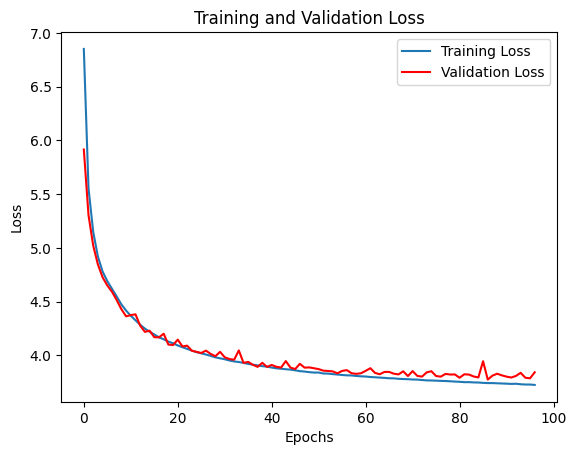

In [55]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Load weights from the checkpoint if available
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Loading weights.")
    mlp_large_pretrained.load_weights(checkpoint_path)
    # Get the number of epochs already run
    try:
        start_epoch = mlp_large_pretrained.history.epoch[-1]
    except:
        start_epoch = 0
    print(f"Resuming training from epoch {start_epoch}.")
else:
    print("No checkpoint found. Training from scratch.")
    start_epoch = 0

indices = np.random.permutation(X_train_full.shape[0])

if TRAIN == True:
    tf.random.set_seed(MODELS_SEED+1)
    history = mlp_large_pretrained.fit(X_train_full[indices], y_train_full[indices], epochs=100, batch_size=256, initial_epoch=start_epoch,
                            validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback])
    plot_loss_history(history)

In [56]:
mlp_large_pretrained.load_weights(checkpoint_path)
evaluation = mlp_large_pretrained.evaluate(X_test_full, y_test_full)

5294/5294 [==============================] - 8s 2ms/step - loss: 3.9433


In [57]:
checkpoint_path = 'saved_models_paper3/ckpoint/mlp_large_finetuned.keras'

mlp_large_finetuned = create_model_finetune(X_train, mlp_large_pretrained, MODELS_SEED)
mlp_large_finetuned.compile(Adam(learning_rate=1e-3), loss=NLL)
mlp_large_finetuned.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 300)               12300     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

Epoch 1/50
1841/1841 [==============================] - 6s 3ms/step - loss: 3.7705 - val_loss: 3.8003
Epoch 2/50
1841/1841 [==============================] - 5s 2ms/step - loss: 3.7229 - val_loss: 3.7627
Epoch 3/50
1841/1841 [==============================] - 5s 3ms/step - loss: 3.7035 - val_loss: 3.7738
Epoch 4/50
1841/1841 [==============================] - 5s 3ms/step - loss: 3.6917 - val_loss: 3.7716
Epoch 5/50
1841/1841 [==============================] - 5s 3ms/step - loss: 3.6838 - val_loss: 3.7219
Epoch 6/50
1841/1841 [==============================] - 5s 3ms/step - loss: 3.6811 - val_loss: 3.6941
Epoch 7/50
1841/1841 [==============================] - 5s 3ms/step - loss: 3.6725 - val_loss: 3.7605
Epoch 8/50
1841/1841 [==============================] - 5s 3ms/step - loss: 3.6750 - val_loss: 3.6835
Epoch 9/50
1841/1841 [==============================] - 5s 2ms/step - loss: 3.6661 - val_loss: 3.7914
Epoch 10/50
1841/1841 [==============================] - 4s 2ms/step - loss: 3.655

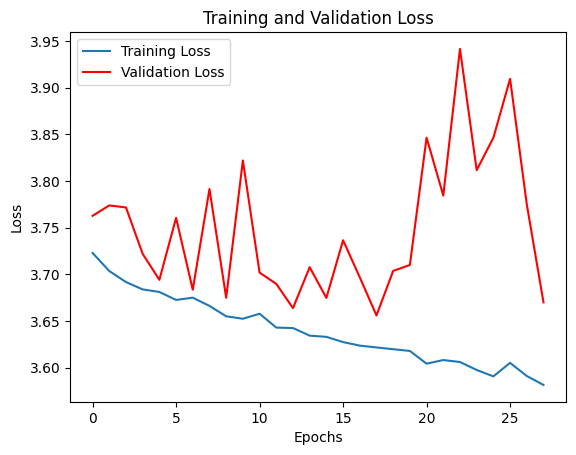

In [58]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

indices = np.random.permutation(X_train.shape[0])

if TRAIN == True:
    history = mlp_large_finetuned.fit(X_train[indices], y_train[indices], epochs=50, batch_size=64,
                                validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
    plot_loss_history(history)

In [59]:
mlp_large_finetuned.load_weights(checkpoint_path)
evaluation = mlp_large_finetuned.evaluate(X_test, y_test)

1023/1023 [==============================] - 2s 2ms/step - loss: 7.2508


In [60]:
y_train_pred = np.array(mlp_large_finetuned(X_train).mean()).ravel()
y_test_pred = np.array(mlp_large_finetuned(X_test).mean()).ravel()

y_train_stddevs = np.array(mlp_large_finetuned(X_train).stddev()).ravel()
y_test_stddevs = np.array(mlp_large_finetuned(X_test).stddev()).ravel()

name = "LPMLP A2"

save_preds(name, y_test_pred, y_test_stddevs, filename="preds_paper.csv")

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL,
                           output_file="results_paper.csv")

Train RMSE: 23.013
Test RMSE: 27.525
Train MAE: 12.424
Test MAE: 14.908
Percentage of Test Data Points within 99.00% CI: 99.20%
Percentage of Test Data Points within 99.00% CI: 97.89%
Percentage of Test Data Points within 95.00% CI: 96.54%
Percentage of Test Data Points within 95.00% CI: 93.09%


## Sparse GP

In [61]:
np.random.seed(42)
kernel = GPy.kern.RBF(input_dim=X_train.shape[1])
num_inducing = 100

# Considering 500 inducing points
gp_inducing = GPy.models.SparseGPRegression(X_train, np.array(y_train).reshape(-1, 1), kernel=kernel, num_inducing=num_inducing)
gp_inducing.optimize(messages=True)

 c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\GPy\kern\src\rbf.py:52: RuntimeWarning:overflow encountered in square


In [62]:
y_train_pred, y_train_vars = gp_inducing.predict(X_train)
y_test_pred, y_test_vars = gp_inducing.predict(X_test)
y_train_pred = y_train_pred.squeeze()
y_test_pred = y_test_pred.squeeze()

if not isinstance(y_train, np.ndarray):
    y_train_full = y_train.to_numpy()
if not isinstance(y_test, np.ndarray):
    y_test_full = y_test.to_numpy()
    
y_train_pred = y_train_pred.squeeze()
y_test_pred = y_test_pred.squeeze()
y_train_stddevs = np.sqrt(y_train_vars.squeeze())
y_test_stddevs = np.sqrt(y_test_vars.squeeze())

name = "GP (RBF, sparse)"

save_preds(name, y_test_pred, y_test_stddevs, filename="preds_paper.csv")

evaluate_and_save_metrics(name,
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL,
                           output_file="results_paper.csv")

Train RMSE: 47.366
Test RMSE: 49.568
Train MAE: 32.172
Test MAE: 33.874
Percentage of Test Data Points within 99.00% CI: 94.05%
Percentage of Test Data Points within 99.00% CI: 93.20%
Percentage of Test Data Points within 95.00% CI: 89.30%
Percentage of Test Data Points within 95.00% CI: 88.06%


## Results

In [63]:
results = pd.read_csv('results_paper.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: BNN
Train RMSE                                         37.45
Train MAE                                          20.6
Test RMSE                                          40.28
Test MAE                                           22.54
Test % within 99.00% CI                            97.18
Test % within 95.00% CI                            91.79


Model: PMLP A1
Train RMSE                                         24.86
Train MAE                                          13.47
Test RMSE                                          28.97
Test MAE                                           15.94
Test % within 99.00% CI                            97.52
Test % within 95.00% CI                            92.21


Model: LPMLP A1
Train RMSE                                         23.91
Train MAE                                          12.9
Test RMSE                                          27.38
Test MAE                                           14.81
Test % within 99.00% CI                     

In [64]:
metrics = results.columns[1:]

# Print results
for idx, row in results.iterrows():
    # print(row['Model Name'])
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass  # If conversion fails, keep the original value
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = row['Model Name'] + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")


BNN 37.45 & 20.60 & 40.28 & 22.54 & 97.18 & 91.79\% \\


PMLP A1 24.86 & 13.47 & 28.97 & 15.94 & 97.52 & 92.21\% \\


LPMLP A1 23.91 & 12.90 & 27.38 & 14.81 & 98.40 & 94.56\% \\


PMLP A2 25.93 & 14.28 & 28.84 & 15.94 & 97.48 & 92.57\% \\


LPMLP A2 23.01 & 12.42 & 27.52 & 14.91 & 97.89 & 93.09\% \\


GP (RBF, sparse) 47.37 & 32.17 & 49.57 & 33.87 & 93.20 & 88.06\% \\


